## RD900 region - identification of duplication events in MTBC

**Objective:**

Identify duplication events in RD900 MTBC using available genome assemblies.

**Method:**

1. identify assemblies to use including sub-sampling MTB an Mbovis genomes by choosing best qualities
2. decide which sub sequences we want to use to detect presence of a gene in contigs
3. for each assembly:
    * make a blast database
    * blast sub-sequence(s) to it
    * store result
4. make a matrix of presence absence for each genome
5. make a species tree and use the blast hit matrix for ancestral state reconstruction

**Links:**

* https://github.com/dmnfarrell/rd900
* https://www.ncbi.nlm.nih.gov/gene/1090581

**Requirements:**

To run this code you should install the following packages with pip:

`pip install biopython bcbio-gff matplotlib pandas seaborn`

<img src="img/pknh_orthologs.png" width=500></img>

In [1]:
import os, glob, subprocess, shutil
import urllib
from importlib import reload
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import tools
pd.set_option("display.width",140)

In [3]:
#samples = pd.read_csv('genomes_data.csv')
assemblies = pd.read_csv('mtb_assemblies.csv')

### Filter assemblies to use

In [4]:
def sample_assemblies(asm, n=10):
    res=[]
    species = asm.species.unique()
    for s in species:
        df=asm[asm.species==s]
        if len(df)>n:
            df=df.sample(n=n, random_state=3)
        res.append(df)
    res=pd.concat(res)
    return res

In [5]:
filtered = assemblies[(assemblies.Level=='Complete Genome') | (~assemblies.species.isin(['mtb']))]
omit = ['PRJNA407834','PRJNA287158','PRJNA214551']
filtered = filtered[~filtered.BioProject.isin(omit)]

filtered = sample_assemblies(filtered, 8)
filtered = filtered[~filtered.species.isin(['marinum','ulcerans','liflandii','microti','canettii'])]

filtered = filtered[~filtered.Assembly_nover.isin(['GCA_000328785','GCA_000328825'])]
print (len(filtered),len(assemblies))
print (filtered.species.value_counts())
#print (filtered.columns)
#print (filtered.BioProject.value_counts())

58 6600
H37Rv         8
bovis         8
mtb           8
africanum     8
BCG           8
CDC           7
pinnipedii    3
H37Ra         3
caprae        3
orygis        2
Name: species, dtype: int64


### test data fetch

In [4]:
url = assemblies.loc[0]['GenBank FTP']
link = tools.get_url_from_path(url)
name = 'GCA_000934325.3'
urllib.request.urlretrieve(link, os.path.join('assemblies', name+'.fa.gz'))

('assemblies/GCA_000934325.3.fa.gz', <email.message.Message at 0x7f81485b6160>)

### determine sequences to blast using sub sequences within africanum RD900 region

In [6]:
rd900seq = SeqIO.read('RD900MAF.fa',format='fasta')
pknh1 = rd900seq[783:2663]
pknh1.id = 'pknh1'
tbd2 = rd900seq[2907:5303]
tbd2.id = 'tbd2'
pknh2 = rd900seq[5314:6981]
pknh2.id='pknh2'
pro_pknh1 = rd900seq[1612:1772]
pro_pknh1.id = 'pro_pknh1'
pro_pknh2 = rd900seq[6081:6153]
pro_pknh2.id = 'pro_pknh2'
pknh2_sensor = rd900seq[5314:6000]
pknh2_sensor.id = 'pknh2_sensor'
#print (pknh2_sensor.seq)
#pro_bov = SeqRecord(Seq('ATCCACCCTGCCCGGCACCGCGGCGGTAACCGCGCAGCCGCCGACCATGCCCACCGTCACACCGCCGCCCATCCAGGCCGCGCCGA'),id='pknh1-bov')
print (pro_pknh2.seq)

CGGCGCGGCCTGGATGGGCGGCGGTGTGACGGTGGGCATGGTCGGCGGCTGCGCGGTTACCGCCGCGGTGCC


### loop over assemblies and get results

Here we loop over each assembly in the table and fetch the file remotely, make a blast db and 

In [ ]:
def blast_assemblies(seqs, df, pcov=.9):
    """blast search a set of assemblies for seqs"""
    result=[]
    for i,row in df.iterrows():
        acc = row.Assembly
        strain = row.Strain
        species = row.species
        full = row.Organism_Name
        print (strain, acc, end='\r')
        url = row['GenBank FTP']
        #get file
        filename = os.path.join('assemblies', acc+'.fa.gz')
        dbname = 'blastdb/%s.nsq' %acc
        if not os.path.exists(filename):
            link = tools.get_url_from_path(url)
            urllib.request.urlretrieve(link, filename)
            #make blast database for this genome
            make_blast_db(filename, out=acc)
        data={}
        for seq in seqs:
            #do blast
            bl = tools.blast_sequences('blastdb/%s' %acc, seq)#, show_cmd=True)
            bl['pcov'] = bl.length/len(seq)
            #print (bl)
            bl = bl[bl.pcov>pcovs]
            if len(bl)>0:
                x = bl.iloc[0]                
                ident = x.pident
            else:
                ident = 0
            data[seq.id] = ident
        data['id'] = row.Assembly_nover
        data['strain'] = strain
        data['species'] = species
        data['name'] = full
        result.append(data)

    result = pd.DataFrame(result)    
    return result

seqs = [pro_pknh1,pro_pknh2,pknh2_sensor]
result = blast_assemblies(seqs, filtered, pcov=.9)
result.to_csv('rd900_region_hits.csv',index=False)

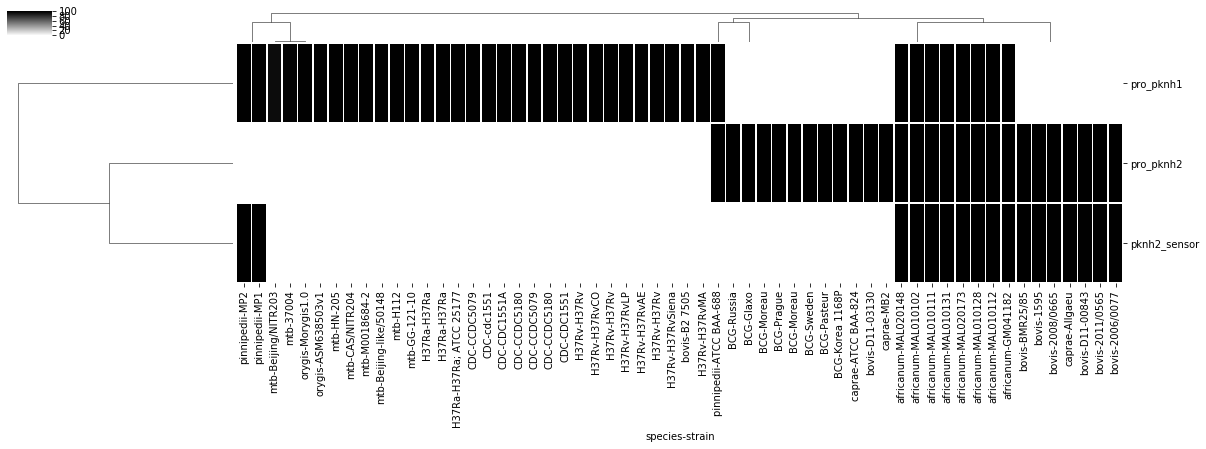

In [8]:
result = pd.read_csv('rd900_region_hits.csv')
X=result.set_index(['species','strain']).drop(columns=['name','id'])
cg=sns.clustermap(X.T,cmap='gray_r',yticklabels=1,lw=.5,figsize=(20,5))
x=plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#sns.heatmap(X.T)

### Species tree with ANIs

pyani: `average_nucleotide_identity.py -o ANIm_out -i temp -m ANIm -f` (too slow)

fastANI: `fastANI --ql reference.txt --rl query.txt -o fastani.out -t 10`

https://github.com/ParBLiSS/FastANI.git

### make file lists for FastANI

In [9]:
names = list(filtered.Assembly_nover)
l=[]
for f in glob.glob('assemblies/*.fa.gz'):
    n=os.path.basename(f).split('.')[0]
    if n in names:
        l.append(f)
print (len(l))
with open('query.txt', 'w') as infile:
    infile.write('\n'.join(l))
shutil.copyfile('query.txt','reference.txt')

58


'reference.txt'

## run fastANI

In [ ]:
cmd = 'fastANI --ql reference.txt --rl query.txt -o fastani.out -t 12'
subprocess.check_output(cmd,shell=True)

In [10]:
def get_fastani():
    import re
    df = pd.read_csv('fastani.out',sep='\t',names=['query','ref','ident','x','y'])
    df['query'] = df['query'].apply(lambda x: re.split(r"[\./]+",x)[1])
    df['ref'] = df['ref'].apply(lambda x: re.split(r"[\./]+",x)[1])
    x = pd.pivot_table(df,index='query',values='ident',columns=['ref'])
    return x

In [14]:
anim = get_fastani()
df = filtered.set_index('Assembly_nover').species
mapping = df.to_dict()
mapping
anim.index = anim.index.map(mapping)
anim['species'] = anim.index.map(mapping)
anim.to_csv('ani_matrix.csv')
#anim.species


In [ ]:
cl=sns.clustermap(anim,xticklabels=1,yticklabels=1,cmap='coolwarm',figsize=(12,12))
cl.savefig('anim_clustermap.png',dpi=150)